# In here I will implement the VGG16 model with only the stft data (1025, 2560) that will be converted to 224x224x3 by copying data

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.models import load_model, Model

# algorithms
import torch
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical
from keras.applications import VGG16


In [2]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [3]:

genre_names = ['rock', 'pop', 'arabesk', 'turk_sanat', 'jazz', 'rap']

# Load the features.pkl file
with open('../../data/features.pkl', 'rb') as file:
    all_features = pickle.load(file)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_features)

# Display the DataFrame (optional)
print(df.shape)

(558, 9)


In [4]:
column_names = list(df.columns)
print(column_names)
print(df['stft_db'][0].shape)

['stft_db', 'spectral_rolloff', 'zcr', 'chroma', 'mfccs', 'rms', 'spectral_centroid', 'file_name', 'label']
(1025, 1280)


In [5]:
# Convert STFT data to 224x224x3 format for VGG input
def preprocess_stft_for_vgg(stft_data):
    # Resize STFT data to 224x224
    resized = torch.nn.functional.interpolate(
        torch.tensor(stft_data).unsqueeze(0).unsqueeze(0),  # Add batch and channel dims
        size=(224, 224),
        mode='bilinear',
        align_corners=False
    ).squeeze(0).squeeze(0)
    
    # Normalize to 0-1 range
    normalized = (resized - resized.min()) / (resized.max() - resized.min())
    
    # Repeat the single channel 3 times to create RGB-like input
    rgb_input = normalized.unsqueeze(0).repeat(3, 1, 1)
    
    # Permute dimensions to get 224x224x3
    rgb_input = rgb_input.permute(1, 2, 0)
    
    return rgb_input

# Convert all STFT data in the dataset
processed_features = []
for stft in df['stft_db']:
    processed_features.append(preprocess_stft_for_vgg(stft))

y = to_categorical(df['label'].values, num_classes=len(genre_names))


In [6]:
print(processed_features[0].shape)

torch.Size([224, 224, 3])


In [7]:
# Convert to tensor
X = torch.stack(processed_features)
print("Processed data shape:", X.shape)  # Should be (n_samples, 224, 224, 3)

Processed data shape: torch.Size([558, 224, 224, 3])


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
checkpoint_dir = "vgg_models/"
os.makedirs(checkpoint_dir, exist_ok=True)

# Load pre-trained VGG16 model (without including top fully connected layers)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the pre-trained layers
for layer in vgg_model.layers:
    layer.trainable = False

# Add classification head
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(genre_names), activation='softmax'))  # Output layer with num_classes units

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)



Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.1923 - loss: 2.1721 - val_accuracy: 0.4222 - val_loss: 1.5251
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.4666 - loss: 1.4496 - val_accuracy: 0.4667 - val_loss: 1.3500
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.5741 - loss: 1.1481 - val_accuracy: 0.5444 - val_loss: 1.1841
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.6936 - loss: 1.0082 - val_accuracy: 0.5778 - val_loss: 1.0662
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.7141 - loss: 0.8699 - val_accuracy: 0.5222 - val_loss: 1.1824
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7341 - loss: 0.7430 - val_accuracy: 0.5667 - val_loss: 1.0516
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.8010 - loss: 0.6332 - val_accuracy: 0.4778 - val_loss: 1.2650
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7473 - loss: 0.6776 - val_accuracy: 0.6222 - val_loss:

In [10]:
# Save the final trained model
model.save(f"vgg_models/vgg16_stft_epoch_10_batch_32.keras")

In [11]:
# Load the saved VGGNet model
saved_model_path = "vgg_models/vgg16_stft_epoch_10_batch_32.keras"
model = load_model(saved_model_path)

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7545 - loss: 0.6461
Test Loss: 0.7031
Test Accuracy: 0.7143
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
Classification Report:
              precision    recall  f1-score   support

        rock       0.80      0.77      0.78        26
         pop       0.72      0.82      0.77        22
     arabesk       0.61      0.73      0.67        15
  turk_sanat       0.71      0.50      0.59        10
        jazz       0.52      0.69      0.59        16
         rap       0.94      0.65      0.77        23

    accuracy                           0.71       112
   macro avg       0.72      0.69      0.69       112
weighted avg       0.74      0.71      0.72       112



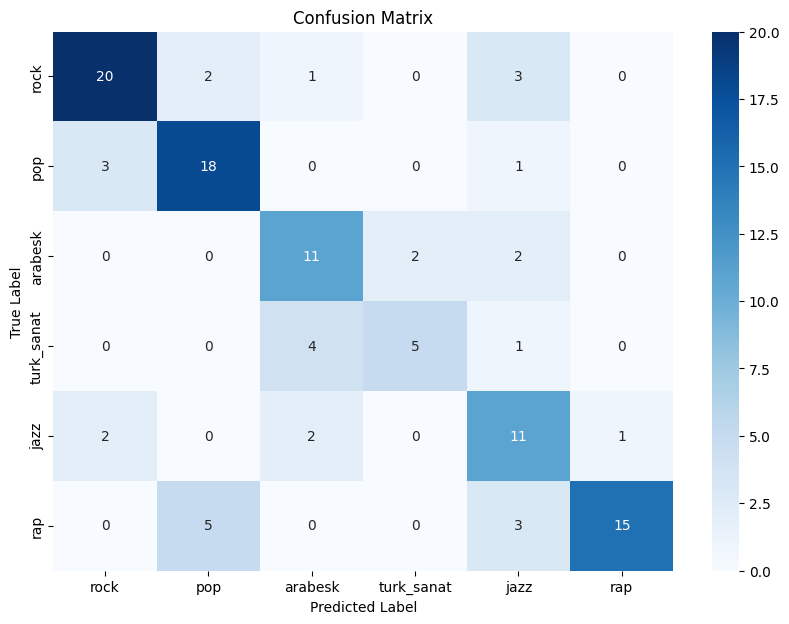

In [12]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predicted probabilities for each class
y_pred_probs = model.predict(X_test)

# Get predicted class labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Get true class labels (already one-hot encoded)
y_true_labels = np.argmax(y_test, axis=1)

# Generate and display a classification report
class_names = genre_names  # List of genre names
classification_rep = classification_report(y_true_labels, y_pred_labels, target_names=class_names)
print("Classification Report:")
print(classification_rep)

# Generate and display a confusion matrix
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 7))
sn.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()